# Learning motion with constant velocity
In this experiment, we are trying to construct a recurrent model that is able to predict the future positions of particle given first two positions. The ground truth is that particle moves with constant speed.

Our setting is the following. There is dense network that is feeded with two first positions of a particle. Output of this network is used to initialize recurrent network that is supposed to predict future positions of a particle. No input is given to recurrent network.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
def get_data(num_samples, timesteps, vnorm=0.03, x0=None, phi0=None):
    """
    Returns data that is needed to train the model
    num_samples is number of samples
    timesteps is number of timesteps to generate
    vnorm is a velocity norm
    x0 is a start position
    phi0 is an angle
    
    returns 
        input_data (first two positions), 
        fake_data (zeros, used to feed RNN) 
        target_data (the rest of trajectory)
    """
    x0 = (np.random.uniform(0.33, 0.66, size=(num_samples, 2)) 
          if x0 is None else x0)
    phi0 = (np.random.uniform(0, 2 * np.pi, size=(num_samples)) 
            if phi0 is None else phi0)
    v = np.stack([np.cos(phi0), np.sin(phi0)], axis=1) * vnorm
    t = np.arange(timesteps + 2)
        
    trajectories = x0[:, np.newaxis, :] + np.einsum('t,sc->stc', t, v)
    # motion with constant speed
    
    input_data = trajectories[:, :2, :]
    target_data = trajectories[:, 2:, :]
    fake_data = np.zeros_like(target_data)
    return input_data, fake_data, target_data

In [7]:
num_samples = 10000
timesteps = 10
input_data, fake_data, target_data = get_data(num_samples, timesteps)

In [8]:
from keras.models import Model, Sequential
from keras.layers import Input, SimpleRNNCell, SimpleRNN, GRU, Dense, Flatten
from keras import backend as K

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


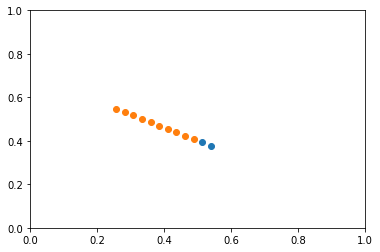

In [9]:
sample = np.random.randint(len(input_data))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(input_data[sample][:, 0], input_data[sample][:, 1], 'o')
plt.plot(target_data[sample][:, 0], target_data[sample][:, 1], 'o')

In [12]:
epochs = 100
latent_dim = 16
batch_size = 64

print('Number of samples:', len(input_data))
print('Sequence length for outputs:', target_data.shape[1])

# Define an input sequence and process it.
inputs = Input(shape=(2, 2))
# two frames, env.n balls and 2 coordinates per ball

initializer = Sequential()
initializer.add(Flatten(batch_input_shape=inputs.shape.as_list()))
initializer.add(Dense(latent_dim,
                activation='relu'))
initializer.add(Dense(latent_dim))

init_state = initializer(inputs)

recurrent = GRU(latent_dim, return_sequences=True, return_state=True)
recurrent_dense = Dense(target_data.shape[2])

fake_input = Input(shape=(None, fake_data.shape[2]))

recurrent_outputs, _= recurrent(fake_input, initial_state=init_state)
recurrent_outputs = recurrent_dense(recurrent_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([inputs, fake_input], recurrent_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='mse')

model.fit([input_data, fake_data], target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('learning_motion.h5')

Number of samples: 10000
Sequence length for outputs: 10
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 3s 411us/step - loss: 0.0635 - val_loss: 0.0285
Epoch 2/100
8000/8000 [==============================] - 3s 361us/step - loss: 0.0266 - val_loss: 0.0252
Epoch 3/100
8000/8000 [==============================] - 2s 241us/step - loss: 0.0234 - val_loss: 0.0219
Epoch 4/100
8000/8000 [==============================] - 2s 224us/step - loss: 0.0210 - val_loss: 0.0201
Epoch 5/100
8000/8000 [==============================] - 1s 172us/step - loss: 0.0201 - val_loss: 0.0195
Epoch 6/100
8000/8000 [==============================] - 1s 180us/step - loss: 0.0196 - val_loss: 0.0191
Epoch 7/100
8000/8000 [==============================] - 3s 313us/step - loss: 0.0192 - val_loss: 0.0207
Epoch 8/100
8000/8000 [==============================] - 2s 249us/step - loss: 0.0189 - val_loss: 0.0184
Epoch 9/100
8000/8000 [==============================] 

8000/8000 [==============================] - 2s 205us/step - loss: 0.0033 - val_loss: 0.0024
Epoch 78/100
8000/8000 [==============================] - 1s 185us/step - loss: 0.0032 - val_loss: 0.0015
Epoch 79/100
8000/8000 [==============================] - 2s 192us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 80/100
8000/8000 [==============================] - 2s 212us/step - loss: 0.0032 - val_loss: 0.0013
Epoch 81/100
8000/8000 [==============================] - 2s 237us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 82/100
8000/8000 [==============================] - 2s 219us/step - loss: 0.0030 - val_loss: 0.0014
Epoch 83/100
8000/8000 [==============================] - 2s 212us/step - loss: 0.0031 - val_loss: 0.0037
Epoch 84/100
8000/8000 [==============================] - 2s 216us/step - loss: 0.0030 - val_loss: 0.0032
Epoch 85/100
8000/8000 [==============================] - 2s 217us/step - loss: 0.0030 - val_loss: 0.0023
Epoch 86/100
8000/8000 [==============================] - 2

/usr/local/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'sequential_3/dense_5/BiasAdd:0' shape=(?, 16) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [13]:
def plot_traj(traj, mode='-', ax=None, label=None):
    tr = traj.reshape(-1, 1, 2)
    for i in range(1):
        if ax is None:
            plt.plot(tr[:, i, 0], tr[:, i, 1], mode, label=label)
        else:
            ax.plot(tr[:, i, 0], tr[:, i, 1], mode, label=label)

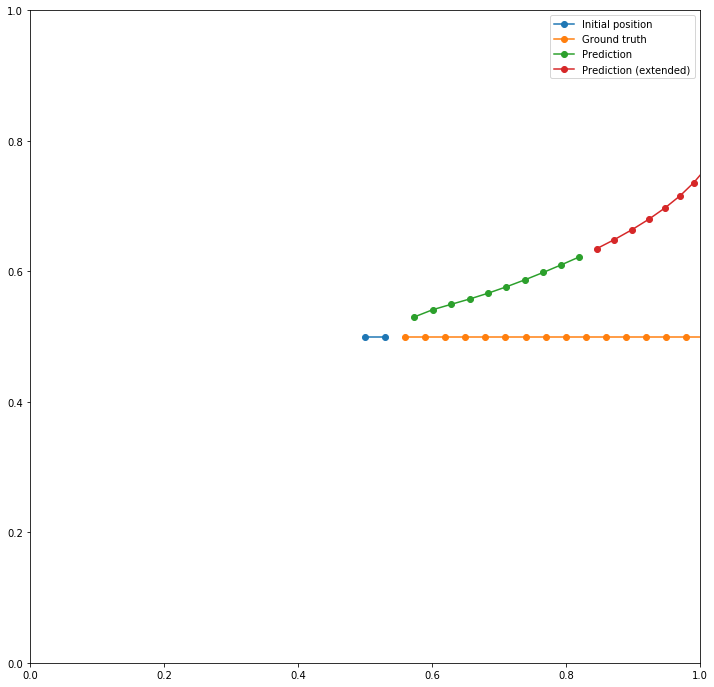

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
def draw(theta, ax):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    test_input_data, test_fake_data, test_target_data = get_data(
        1, timesteps * 2, x0=np.array([[0.5, 0.5]]), phi0 = np.array([theta]))
    prediction = model.predict([test_input_data,
                                test_fake_data])
    plot_traj(test_input_data[0], mode='o-', label="Initial position", ax=ax)
    plot_traj(test_target_data[0], mode='o-', label='Ground truth', ax=ax)
    plot_traj(prediction[0, :timesteps], mode='o-', label='Prediction', ax=ax)
    plot_traj(prediction[0, timesteps:], mode='o-', label='Prediction (extended)', 
               ax=ax)
    plt.legend()
draw(0, ax)

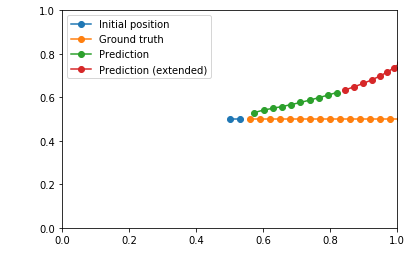

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

def show_ani():
    """
    Shows an animation of trajectories for rotating angle
    """
    def ani_frame():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        draw(0, ax)

        def update_img(n):
            ax.clear()
            draw(n/10, ax=ax)
            return ax

        ani = animation.FuncAnimation(fig, update_img, 100,
                                      interval=100)
        writer = animation.writers['ffmpeg'](fps=30)

        return ani

    ani = ani_frame()
    return HTML(ani.to_html5_video())
show_ani()